In [1]:
from sklearn.datasets import load_breast_cancer

In [3]:
df = load_breast_cancer(as_frame=True)

In [4]:
X = df.data
y = df.target

In [5]:
from sklearn.model_selection import train_test_split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42)

In [77]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [78]:
knn_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

In [79]:
knn_grid = {
    "knn__n_neighbors": np.arange(1,31,2)
}

In [80]:
knn = GridSearchCV(
    knn_pipe,
    knn_grid,
    cv = 5,
    n_jobs = -1
)

In [81]:
lr_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression())
])

In [82]:
lr_grid = {
    "lr__C": np.logspace(-3,3,50)
}

In [83]:
lr = GridSearchCV(
    lr_pipe,
    lr_grid,
    cv = 5,
    n_jobs = -1
)

In [48]:
from sklearn.metrics import ( accuracy_score, precision_score, 
recall_score, f1_score, confusion_matrix, roc_curve, auc)
import pandas as pd
import matplotlib.pyplot as plt

In [85]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test):

    model.fit(X_train, y_train)

    best_model = model.best_estimator_
    
    #Test
    y_test_pred = best_model.predict(X_test)
    y_test_prob = best_model.predict_proba(X_test)[:,1]
    
    acc_test = accuracy_score(y_test, y_test_pred)
    pre_test = precision_score(y_test, y_test_pred)
    rec_test = recall_score(y_test, y_test_pred)
    f1_test = f1_score(y_test, y_test_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)
    
    print(f"{'-'*40}")
    print(f"{name} Confusion Matrix:")
    print(f"{'-'*40}")
    print(cm_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
    roc_auc = auc(fpr, tpr)

    youden_j = tpr - fpr
    optimal_index = np.argmax(youden_j)
    optimal_threshold = thresholds[optimal_index]
    print("Optimal Threshold: ", optimal_threshold)
    
    plt.plot(fpr, tpr, color="m", label=f"{name} AUC = {roc_auc:.2f}")
    plt.plot([0,1],[0,1], 'k--', label="By Chance")
    plt.scatter(fpr[optimal_index], tpr[optimal_index], color="green")
    plt.legend()
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.grid()
    plt.show()

    results = pd.DataFrame([
        {"Model":name, "Split":"Testing", "Accuracy": acc_test, 
         "Precision":pre_test, "Recall":rec_test, "F1": f1_test}
    ])
    
    return results

----------------------------------------
KNN Confusion Matrix:
----------------------------------------
[[40  3]
 [ 3 68]]
Optimal Threshold:  0.8


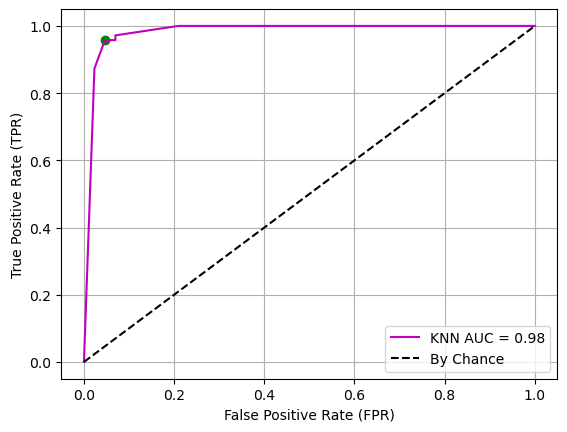

----------------------------------------
LR Confusion Matrix:
----------------------------------------
[[41  2]
 [ 1 70]]
Optimal Threshold:  0.5348096224630985


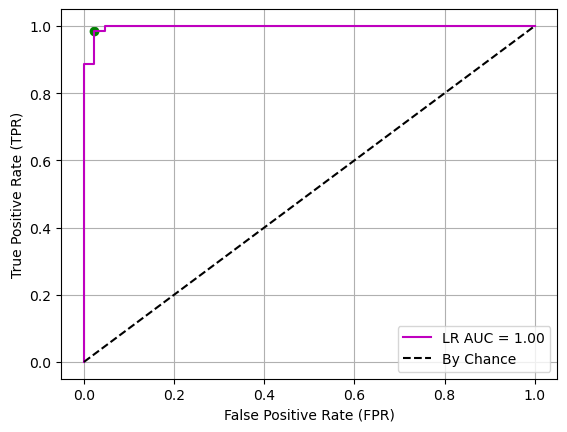

,Model,Split,Accuracy,Precision,Recall,F1
0,KNN,Testing,0.947368,0.957746,0.957746,0.957746
0,LR,Testing,0.973684,0.972222,0.985915,0.979021


In [86]:
pd.concat([
    evaluate_model("KNN", knn, X_train, y_train, X_test, y_test),
    evaluate_model("LR", lr, X_train, y_train, X_test, y_test)
])